In [3]:
# TEXT ANALYSIS 
# BASED ON MILLER (2015) and RASCHKA (2015)

# import packages for text processing and multivariate analysis
import re  # regular expressions
import nltk  # draw on the Python natural language toolkit
import pandas as pd  # DataFrame structure and operations
import numpy as np  # arrays and numerical processing
import scipy
import matplotlib.pyplot as plt  # 2D plotting

# terms-by-documents matrix
from sklearn.feature_extraction.text import CountVectorizer

# alternative distance metrics for multidimensional scaling
from sklearn.metrics import euclidean_distances 
from sklearn.metrics.pairwise import linear_kernel as cosine_distances
from sklearn.metrics.pairwise import manhattan_distances as manhattan_distances

from sklearn import manifold  # multidimensional scaling
from sklearn.cluster import KMeans  # cluster analysis by partitioning
from sklearn.decomposition import PCA  # principal component analysis

from nltk.corpus import stopwords
stopwords = nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jdine\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [4]:
# define list of codes to be dropped from documents
# carriage-returns, line-feeds, tabs
codelist = ['\r', '\n', '\t']    

# contractions and other word strings to drop from further analysis, adding
# to the usual English stopwords to be dropped from the document collection
more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
    'shes','thats','theres','theyre','wont','youll','youre','youve',\
    're','tv','g','us','en','ve','vg','didn','pg','gp','our','we',
    'll','film','video','name','years','days','one','two','three',\
    'four','five','six','seven','eight','nine','ten','eleven','twelve'] 
# start with the initial list and add to it for movie text work 
stoplist = nltk.corpus.stopwords.words('english') + more_stop_words 


In [6]:
# text parsing function for creating text documents 
# there is more we could do for data preparation 
# stemming... looking for contractions... possessives... 
# but we will work with what we have in this parsing function
# if we want to do stemming at a later time, we can use
#     porter = nltk.PorterStemmer()  
# in a construction like this
#     words_stemmed =  [porter.stem(word) for word in initial_words]  
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    # replace selected character strings/stop-words with space
    for i in range(len(stoplist)):
        stopstring = ' ' + str(stoplist[i]) + ' '
        temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string)    


In [8]:
# read in the comma-delimited text file with from initial data
# preparation... create the movies data frame for analysis
movies = pd.read_csv('movie_tagline_data_parsed.csv') 

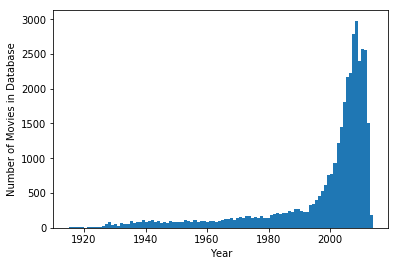

In [9]:
# EXPLORATORY DATA ANALYSIS

# plot frequency of movies by year... histogram
plt.figure()
plt.hist(movies['year'], bins= 100)
plt.xlabel('Year')
plt.ylabel('Number of Movies in Database')
plt.show()
plt.savefig('fig_text_movies_by_year_histogram.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='landscape', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)  

In [10]:
# we work with movies from 1974 to 2013
# create aggregate tagline_text collection for each year of interest
year = []  # initialize year list
tagline_text = []  # initialize aggregate tagline text
parsed_text = []  # parsed tagline text for subsequent analysis 
aggregate_document = ''  # intialize aggregate taglines document
for iyear in range(1974,2014):
    year.append(iyear)
    gather_taglines = ''  # initialize aggregate tagline text
    this_year_data_frame = movies[movies['year'] == iyear]
    for this_record_index in this_year_data_frame.index.values:
        this_record = this_year_data_frame.ix[this_record_index]
        gather_taglines = gather_taglines + this_record['tagline']    
    tagline_text.append(gather_taglines)
    parsed_text.append(text_parse(gather_taglines))
    aggregate_document = aggregate_document + gather_taglines
big_bag_of_words = text_parse(aggregate_document)
    
# create document collection... 40 years of data = 40 documents
tagline_data = {'year': year, 'tagline_text':tagline_text,\
    'parsed_text':parsed_text}        
tagline_data_frame = pd.DataFrame(tagline_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [21]:
# create terms-by-documents matrix from the parsed text
# extracting the top 200 words in the tagline corpus
tdm_method = CountVectorizer(max_features = 200, binary = True)
examine_movies_tdm = tdm_method.fit(parsed_text)
top_words = examine_movies_tdm.get_feature_names()

# get clean printing of the top words 
print('\nTop 200 words in movie taglines database\n')
print(map(lambda t: t.encode('ascii'), top_words))  # print sans unicode

# extract the terms-by-documents matrix 
# in scipy compressed sparse column format
sparse_movies_tdm = tdm_method.fit_transform(parsed_text)
# convert sparse matrix into regular terms-by-documents matrix
movies_tdm = sparse_movies_tdm.todense()
# define the documents-by-terms matrix 
movies_dtm = movies_tdm.transpose()


Top 200 words in movie taglines database



In [12]:
# dissimilarity measures and multidimensional scaling
# consider alternative pairwise distance metrics from sklearn modules
# euclidean_distances, cosine_distances, manhattan_distances (city-block)
# note that different metrics provide different solutions
# movies_distance_matrix = euclidean_distances(movies_tdm)
# movies_distance_matrix = manhattan_distances(movies_tdm)
movies_distance_matrix = cosine_distances(movies_tdm)

mds_method = manifold.MDS(n_components = 2, random_state = 9999,\
    dissimilarity = 'precomputed')
mds_fit = mds_method.fit(movies_distance_matrix)  
mds_coordinates = mds_method.fit_transform(movies_distance_matrix) 

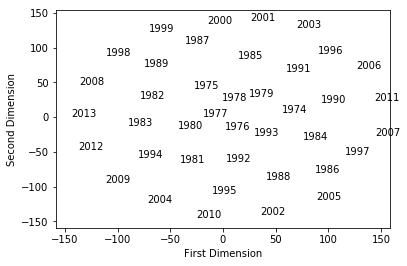

In [13]:
# plot tagline text for years in two dimensions 
# defined by multidimensional scaling
plt.figure()
plt.scatter(mds_coordinates[:,0],mds_coordinates[:,1],\
    facecolors = 'none', edgecolors = 'none')  # plots points in white (invisible)
labels = []
for iyear in range(1974,2014):
    labels.append(str(iyear))  
for label, x, y in zip(labels, mds_coordinates[:,0], mds_coordinates[:,1]):
    plt.annotate(label, (x,y), xycoords = 'data')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')    
plt.show()
plt.savefig('fig_text_mds_1974_2013.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='landscape', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)  

In [14]:
# use transpose of the terms-by-document matrix and cluster analysis
# try five clusters/groups of words
clustering_method = KMeans(n_clusters = 5, random_state = 9999) 
clustering_solution = clustering_method.fit(movies_dtm)
cluster_membership = clustering_method.predict(movies_dtm)
word_distance_to_center = clustering_method.transform(movies_dtm)

# top words data frame for reporting k-means clustering results
top_words_data = {'word': top_words, 'cluster': cluster_membership,\
    'dist_to_0': word_distance_to_center[0:,0],\
    'dist_to_1': word_distance_to_center[0:,1],\
    'dist_to_2': word_distance_to_center[0:,2],\
    'dist_to_3': word_distance_to_center[0:,3],\
    'dist_to_4': word_distance_to_center[0:,4]}
distance_name_list = ['dist_to_0','dist_to_1','dist_to_2','dist_to_3','dist_to_4']    
top_words_data_frame = pd.DataFrame(top_words_data)
for cluster in range(5):
    words_in_cluster =\
        top_words_data_frame[top_words_data_frame['cluster'] == cluster] 
    sorted_data_frame =\
        top_words_data_frame.sort_index(by = distance_name_list[cluster],\
        ascending = True)
    print('\n Top Words in Cluster :',cluster,'------------------------------')
    print(sorted_data_frame.head())
    


 Top Words in Cluster : 0 ------------------------------
     cluster  dist_to_0  dist_to_1  dist_to_2  dist_to_3  dist_to_4    word
171        0   1.339175   1.954291   1.619526   1.804547   1.653595  things
189        0   1.405420   2.289171   2.140572   1.989747   2.521780    wild
135        0   1.529328   2.171172   2.062891   2.082660   2.117634    past
133        0   1.558766   2.412313   2.305806   1.982944   2.287876   party
162        2   1.558766   1.582233   1.381514   1.656164   2.027159    stop

 Top Words in Cluster : 1 ------------------------------
     cluster  dist_to_0  dist_to_1  dist_to_2  dist_to_3  dist_to_4   word
71         2   1.851959   1.065383   1.025396   1.528880   1.690969  girls
183        2   1.851959   1.065383   1.025396   1.528880   1.690969   want
73         1   2.061052   1.137074   1.388880   1.766708   1.964529  going
83         1   2.016461   1.204504   1.366661   1.766708   1.727534   high
128        2   1.671343   1.247435   0.303732   1.224

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  


In [15]:
# could examine possible clustering solutions with partitioning
# by changing the n_clusters setting for KMeans

# a five-cluster solution seems to make sense with words
# toward the center of each cluster fitting together
# let's use pairs of top words from each cluster to name the clusters
# cluster index 0: forever-hero
# cluster index 1: best-high
# cluster index 2: young-comedy
# cluster index 3: everything-family
# cluster index 4: going-real

# name the clusters in the top words data frame
cluster_to_name = {0:'forever-hero',\
    1:'best-high', 2:'young-comedy',\
    3:'everything-family', 4:'going-real'}
top_words_data_frame['cluster_name'] = top_words_data_frame['cluster'].map(cluster_to_name)

In [16]:
# use word clusters to define text measures...
# in particular, let the raw score for a cluster for a year be the percentage
# of words in that year's tagline documents that fall within the cluster
# then to examine movies in time, standardize cluster scores across the
# forty years of the study and plot as a multiple time series
forever_hero_df =\
    top_words_data_frame[top_words_data_frame['cluster'] == 0]     
forever_hero_word_list = str(forever_hero_df['word'])  

best_high_df =\
    top_words_data_frame[top_words_data_frame['cluster'] == 1]     
best_high_word_list = str(best_high_df['word'])  

young_comedy_df =\
    top_words_data_frame[top_words_data_frame['cluster'] == 2]     
young_comedy_word_list = str(young_comedy_df['word'])  

everything_family_df =\
    top_words_data_frame[top_words_data_frame['cluster'] == 3]     
everything_family_word_list = str(everything_family_df['word'])  

going_real_df =\
    top_words_data_frame[top_words_data_frame['cluster'] == 4]     
going_real_word_list = str(going_real_df['word'])  

In [17]:
# cluster scores as percentage of total words
def cluster_scoring(cluster_count, total_count):
    return (100 * (cluster_count/total_count))
                                                                    
# initialize word counts    
forever_hero_words = []; best_high_words = []; young_comedy_words = []; 
everything_family_words = []; going_real_words = []; total_words = []
# initialize cluster scores
forever_hero = []; best_high = []; young_comedy = []; 
everything_family = []; going_real = []
# compute text measures for each year
for iyear in range(len(year)):
    text = parsed_text[iyear]  # this year's text for scoring
    total_count = len([w for w in text.split()])
    total_words.append(total_count)
    
    forever_hero_count =\
        len([w for w in text.split() if w in forever_hero_word_list])
    forever_hero_words.append(forever_hero_count)
    forever_hero.append(cluster_scoring(forever_hero_count, total_count))
    
    best_high_count =\
         len([w for w in text.split() if w in best_high_word_list])
    best_high_words.append(best_high_count)
    best_high.append(cluster_scoring(best_high_count, total_count))
    
    young_comedy_count =\
        len([w for w in text.split() if w in young_comedy_word_list])
    young_comedy_words.append(young_comedy_count)
    young_comedy.append(cluster_scoring(young_comedy_count, total_count))    
        
    everything_family_count =\
        len([w for w in text.split() if w in everything_family_word_list])
    everything_family_words.append(everything_family_count)
    everything_family.append\
        (cluster_scoring(everything_family_count, total_count))    
        
    going_real_count =\
        len([w for w in text.split() if w in going_real_word_list])    
    going_real_words.append(going_real_count)
    going_real.append(cluster_scoring(going_real_count, total_count))   

add_cluster_data = {'total_words':total_words,\
    'forever_hero_words':forever_hero_words,\
    'forever_hero':forever_hero,\
    'best_high_words':best_high_words,\
    'best_high':best_high,\
    'young_comedy_words':young_comedy_words,\
    'young_comedy':young_comedy,\
    'everything_family_words':everything_family_words,\
    'everything_family':everything_family,\
    'going_real_words':going_real_words,\
    'going_real':going_real}   
add_cluster_data_frame = pd.DataFrame(add_cluster_data)      
tagline_data_frame =\
    pd.concat([tagline_data_frame,add_cluster_data_frame],axis=1) 

# check text measure calculations
print(tagline_data_frame.describe())
print(tagline_data_frame.head())
print(tagline_data_frame.tail())


              year  best_high  best_high_words  everything_family  \
count    40.000000  40.000000        40.000000          40.000000   
mean   1993.500000   7.346018       379.800000           8.821036   
std      11.690452   0.726043       353.594234           1.081050   
min    1974.000000   5.962411        83.000000           4.182754   
25%    1983.750000   7.011300       122.750000           8.567324   
50%    1993.500000   7.420428       169.500000           8.993918   
75%    2003.250000   7.808448       583.750000           9.341642   
max    2013.000000   8.721751      1237.000000          10.364146   

       everything_family_words  forever_hero  forever_hero_words  going_real  \
count                40.000000     40.000000           40.000000   40.000000   
mean                452.750000      1.841238           94.650000    2.666865   
std                 416.035486      0.453633           87.580454    0.504280   
min                  65.000000      0.752233           16.

In [18]:
print(tagline_data_frame.head())
print(tagline_data_frame.tail())

                                         parsed_text  \
0   funniest police shows ever funniest police co...   
1   mosaiken und fresken als zeugen der geschicht...   
2   let poisons lurk mud hatch maryland lottery l...   
3   soup rob old tricks get ready match stars may...   
4   searching star called earth first win great w...   

                                        tagline_text  year  best_high  \
0    One of the Funniest Police Shows Ever One of...  1974   7.776428   
1    Mosaiken und Fresken als Zeugen der Geschich...  1975   7.189542   
2    Let all the poisons that lurk in the mud hat...  1976   7.915058   
3    Soup and Rob are up to their old tricks agai...  1977   6.134516   
4    They were searching for a star called Earth,...  1978   6.701031   

   best_high_words  everything_family  everything_family_words  forever_hero  \
0              128           8.323208                      137      1.336574   
1              110           7.124183                      109  

In [19]:
# compute text measure standard scores across years 
tagline_data_frame['z_forever_hero'] =\
    tagline_data_frame['forever_hero'].\
    apply(lambda d: (d - tagline_data_frame['forever_hero'].mean())/\
    tagline_data_frame['forever_hero'].std())
    
tagline_data_frame['z_best_high'] =\
    tagline_data_frame['best_high'].\
    apply(lambda d: (d - tagline_data_frame['best_high'].mean())/\
    tagline_data_frame['best_high'].std())    
    
tagline_data_frame['z_young_comedy'] =\
    tagline_data_frame['young_comedy'].\
    apply(lambda d: (d - tagline_data_frame['young_comedy'].mean())/\
    tagline_data_frame['young_comedy'].std())    

tagline_data_frame['z_everything_family'] =\
    tagline_data_frame['everything_family'].\
    apply(lambda d: (d - tagline_data_frame['everything_family'].mean())/\
    tagline_data_frame['everything_family'].std())    
        
tagline_data_frame['z_going_real'] =\
    tagline_data_frame['going_real'].\
    apply(lambda d: (d - tagline_data_frame['going_real'].mean())/\
    tagline_data_frame['going_real'].std())            
                

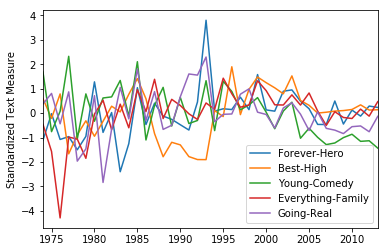

In [20]:
# prepare data frame for multiple time series plot
prelim_mts = pd.DataFrame(tagline_data_frame, columns =\
    ['year', 'z_forever_hero', 'z_best_high', 'z_young_comedy',\
    'z_everything_family', 'z_going_real'])
prelim_mts.rename(columns = {'z_forever_hero':'Forever-Hero',\
    'z_best_high':'Best-High', 'z_young_comedy':'Young-Comedy',\
    'z_everything_family':'Everything-Family',\
    'z_going_real':'Going-Real'}, inplace = True)
mts = prelim_mts.set_index('year')    

# generate the plot  
mts.plot()
plt.xlabel('')
plt.ylabel('Standardized Text Measure')
plt.show()
plt.savefig('fig_text_mts_1974_2013.pdf', 
    bbox_inches = 'tight', dpi=None,  
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)  
    